In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from mat2json import loadMat
from util import getBatteryCapacity, getChargingValues, getDischargingValues, getDataframe, series_to_supervised, rollingAverage
from keras.callbacks import EarlyStopping

In [2]:
import keras.backend as K
import numpy as np


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # From: https://github.com/philipperemy/keras-visualize-activations
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y

In [3]:
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, Permute, Lambda, RepeatVector, Flatten
from keras.models import Model
from keras import backend as K
import numpy as np

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset, look_back):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

# Multidimensional normalization returns data and maximum and minimum values
def NormalizeMult(data):
    #normalize used for denormalization
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0,data.shape[1]):
        #Column i
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

# Multidimensional denormalization
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data


def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [4]:
B0005 = loadMat('B0005.mat')
B0006 = loadMat('B0006.mat')
B0007 = loadMat('B0007.mat')


In [5]:
dfB0005 = getDataframe(B0005)

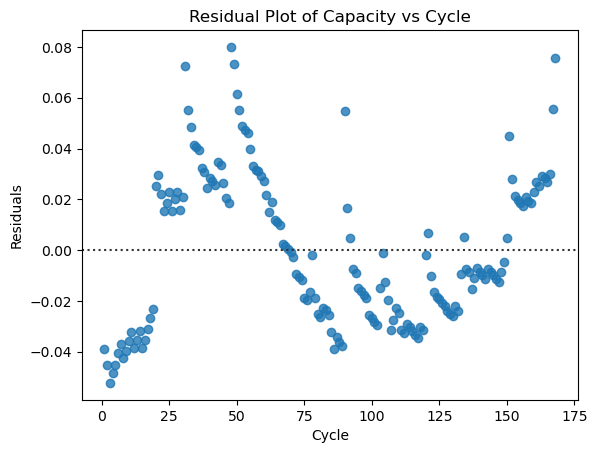

In [6]:
sns.residplot(x='cycle', y='capacity', data=dfB0005)
plt.title('Residual Plot of Capacity vs Cycle')
plt.xlabel('Cycle')
plt.ylabel('Residuals')
plt.show()

In [7]:
dfB0006 = getDataframe(B0006)
dfB0007 = getDataframe(B0007)

dfB0006

#X = dfB0007['cycle']
#Y = dfB0007['capacity']

,cycle,capacity,max_discharge_temp,max_charge_temp
0,1,2.035338,39.162987,27.355870
1,2,2.025140,39.246203,31.874973
2,3,2.013326,38.999202,32.149173
3,4,2.013285,38.843628,32.017074
4,5,2.000528,38.977989,31.921070
...,...,...,...,...
163,164,1.153818,41.149193,28.612333
164,165,1.164401,41.262683,28.542199
165,166,1.158797,41.457918,28.565426
166,167,1.174975,41.116662,28.631428


In [8]:
dfB0007
print(dfB0007.columns)
print(dfB0007.shape)

Index(['cycle', 'capacity', 'max_discharge_temp', 'max_charge_temp'], dtype='object')
(168, 4)


In [9]:
INPUT_DIMS = 4
TIME_STEPS = 10
lstm_units = 64

In [10]:
#Normalized
data,normalize = NormalizeMult(dfB0007)
capacity_data = data[:,0].reshape(len(dfB0007),1)

(4, 2)


In [11]:
train_X, _ = create_dataset(data,TIME_STEPS)
_ , train_Y = create_dataset(capacity_data,TIME_STEPS)


In [12]:
train_X.shape

(157, 10, 4)

In [13]:
train_Y.shape

(157, 1)

In [14]:
train_X, _ = create_dataset(data,TIME_STEPS)
_ , train_Y = create_dataset(capacity_data,TIME_STEPS)

print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
m.compile(optimizer='adam', loss='mse')
m.fit([train_X], train_Y, epochs=100, batch_size=32, validation_split=0.2)
#m.save("./model.h5")
#np.save("normalize.npy",normalize)

(157, 10, 4) (157, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 64)       320         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 10, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 bidirectional (Bidirectional)  (None, 10, 128)      66048       ['dropout[0][0]']                
                                                                        

In [21]:
from sklearn.model_selection import train_test_split
train_size = int(len(dfB0007)*0.8)
train = dfB0007.iloc[:train_size,:]
test = dfB0007.iloc[train_size:,:]
#train, test = train_test_split(df, test_size=0.1)
print("len(train):",len(train))
print("len(test):",len(test))

len(train): 134
len(test): 34


In [22]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
     

In [24]:
!rm model.h5

'rm' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model.h5'
# TRAIN
INPUT_DIMS = 4
TIME_STEPS = 10
lstm_units = 64

#Normalized
train,normalize = NormalizeMult(train)
capacity_data = train[:,0].reshape(len(train),1)

train_X, _ = create_dataset(train,TIME_STEPS)
_ , train_Y = create_dataset(capacity_data,TIME_STEPS)
print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
#m.compile(optimizer='adam', loss='mse')
m.compile(loss='mse', optimizer='adam',metrics=['mae',r2_keras])

# fit the network
history =  m.fit([train_X], train_Y, epochs=100, batch_size=32, validation_split=0.2)
#history = m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                       ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#          )

(4, 2)
(123, 10, 4) (123, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 10, 64)       320         ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 10, 64)       0           ['conv1d_1[0][0]']               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 10, 128)     66048       ['dropout_2[0][0]']              
 )                                                             

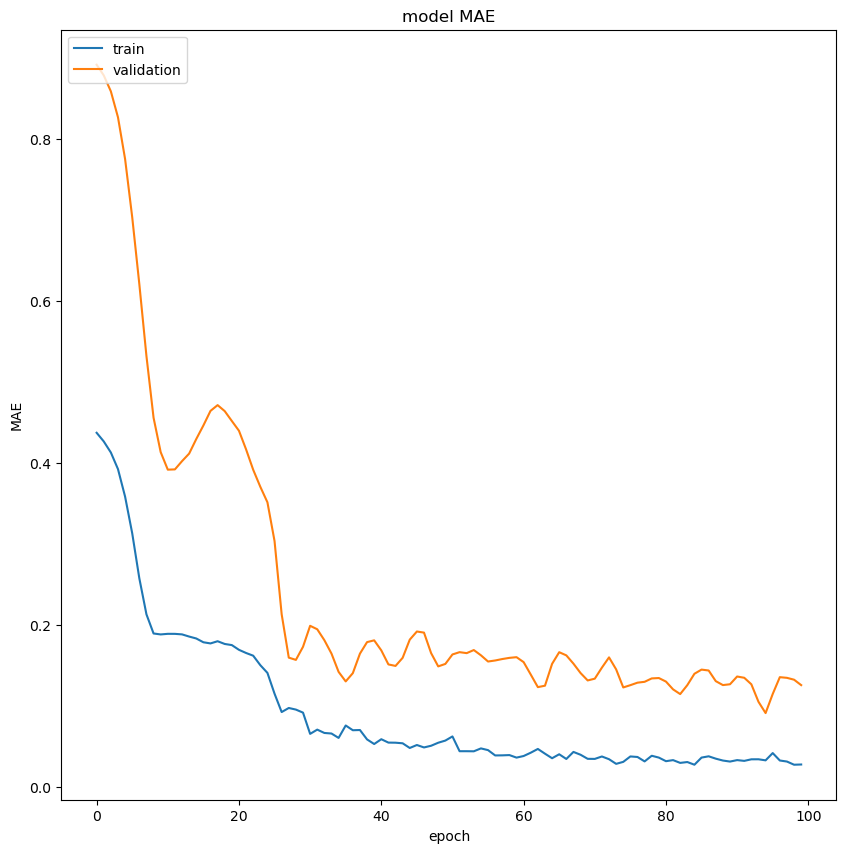

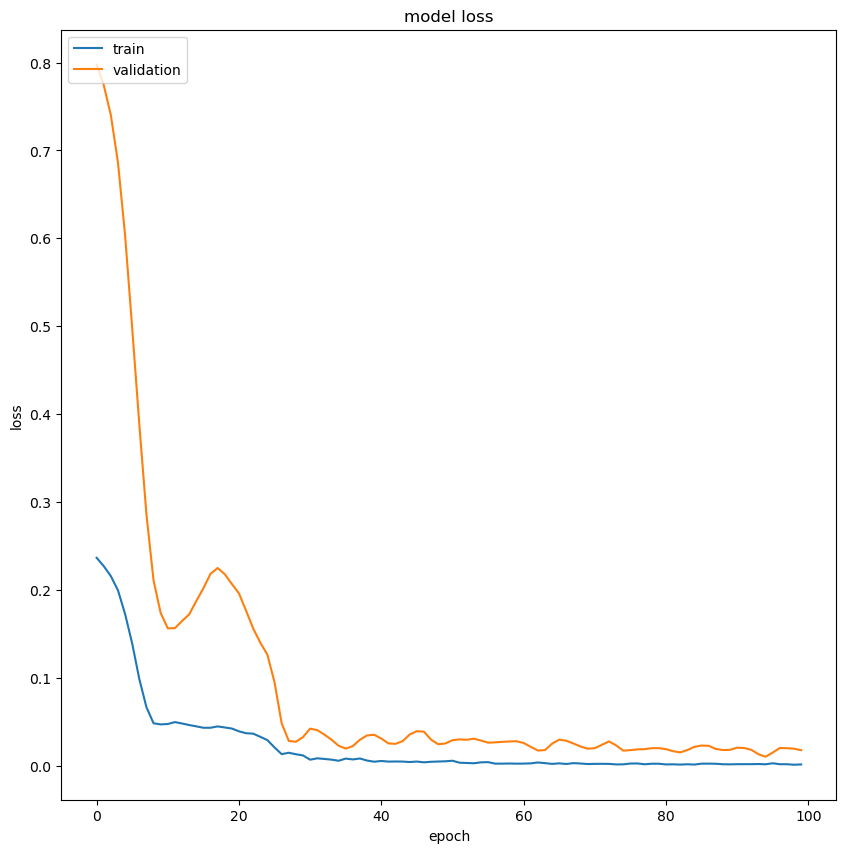

In [26]:
import matplotlib.pyplot as plt

# summarize history for R^2
#fig_acc = plt.figure(figsize=(10, 10))
#plt.plot(history.history['r2_keras'])
#plt.plot(history.history['val_r2_keras'])
#plt.title('model r^2')
#plt.ylabel('R^2')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
# TEST
test,normalize = NormalizeMult(test)
capacity_test = test[:,0].reshape(len(test),1)

test_X, _ = create_dataset(test,TIME_STEPS)
_ , test_Y = create_dataset(capacity_test,TIME_STEPS)
print(test_X.shape,test_Y.shape)

(4, 2)
(23, 10, 4) (23, 1)


In [28]:
scores_test = m.evaluate([test_X], test_Y, verbose=2)

1/1 - 0s - loss: 0.0279 - mae: 0.1484 - r2_keras: 0.3089 - 21ms/epoch - 21ms/step


In [29]:
scores_test


[0.0279230996966362, 0.14844824373722076, 0.30890339612960815]

In [30]:
results = m.predict([test_X])
results

1/1 [==============================] - 1s 898ms/step


array([[0.21069878],
       [0.24710375],
       [0.29094332],
       [0.33329782],
       [0.3699676 ],
       [0.39657772],
       [0.42165998],
       [0.43673667],
       [0.4580175 ],
       [0.47212067],
       [0.48912075],
       [0.50460094],
       [0.5238598 ],
       [0.542804  ],
       [0.5525694 ],
       [0.56286716],
       [0.5757396 ],
       [0.5987532 ],
       [0.61187327],
       [0.6317768 ],
       [0.6486031 ],
       [0.66720057],
       [0.67516196]], dtype=float32)

In [31]:
test_Y

array([[0.3030303 ],
       [0.33333333],
       [0.36363636],
       [0.39393939],
       [0.42424242],
       [0.45454545],
       [0.48484848],
       [0.51515152],
       [0.54545455],
       [0.57575758],
       [0.60606061],
       [0.63636364],
       [0.66666667],
       [0.6969697 ],
       [0.72727273],
       [0.75757576],
       [0.78787879],
       [0.81818182],
       [0.84848485],
       [0.87878788],
       [0.90909091],
       [0.93939394],
       [0.96969697]])

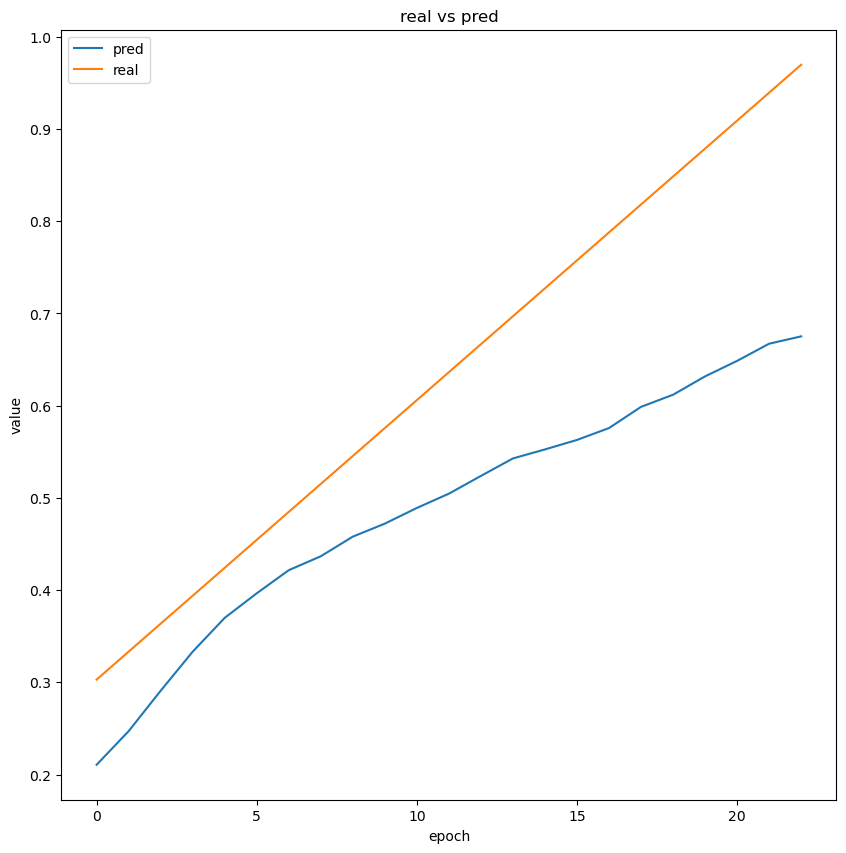

In [32]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(results[:100])
plt.plot(test_Y[:100])
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['pred', 'real'], loc='upper left')
plt.show()